 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timsainb/tensorflow2-generative-models/blob/master/7.0-Tensorflow-spectrograms-and-inversion.ipynb)
 
## Spectrogramming, Mel Scaling, and Inversion in Tensorflow

Tensorflow as a signal processing package that allows us to generate spectrograms from waveforms in numpy. This notebook can serve as background for the Iterator for Nsynth notebook, or for any other spectrogram inversion in Tensorflow project. Spectrogram inversion is done using the Griffin-Lim algorithm. 

![spectrogram inversion in tensorflow 2.0](imgs/spectrogram-inversion.png)

### Install packages if in colab

In [ ]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = [
    "pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513",
    "pip install soundfile",
]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

### load packages

In [3]:
import urllib.request
import io
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import IPython
%matplotlib inline

In [4]:
import tensorflow as tf

In [5]:
print(tf.__version__)

2.0.0-dev20190510


### download and load the waveform

In [6]:
url = "https://raw.githubusercontent.com/timsainb/python_spectrograms_and_inversion/master/bushOffersPeace.wav"

In [7]:
response = urllib.request.urlopen(url)
data, samplerate = sf.read(io.BytesIO(response.read()))

In [8]:
IPython.display.Audio(data=data, rate=samplerate)

(-10027.050000000001, 210568.05, -0.7884475708007812, 0.8979751586914062)

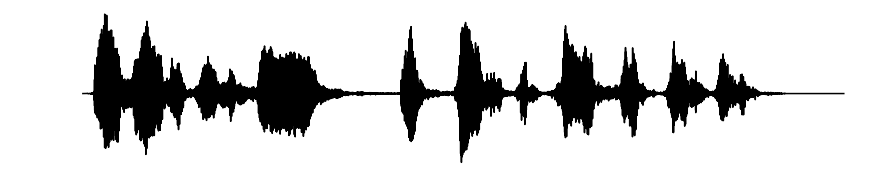

In [9]:
fig, ax = plt.subplots(ncols=1, figsize=(15,3))
ax.plot(data, color = 'k')
ax.axis('off')

### Create the spectrogram
These are a set of spectrogramming functions in tensorflow. They are largely based on [keithito's implementation of tacotron](https://github.com/keithito/tacotron/blob/master/util/audio.py) and [Kyubyong's spectrogramming tutorial](https://github.com/Kyubyong/tensorflow-exercises/blob/master/Audio_Processing.ipynb). Some parts are based on functions from [Librosa](https://librosa.github.io/librosa/)

In [10]:
def _normalize_tensorflow(S, hparams):
    return tf.clip_by_value((S - hparams.min_level_db) / -hparams.min_level_db, 0, 1)

def _tf_log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator


def _amp_to_db_tensorflow(x):
    return 20 * _tf_log10(tf.clip_by_value(tf.abs(x), 1e-5, 1e100))


def _stft_tensorflow(signals, hparams):
    return tf.signal.stft(
        signals,
        hparams.win_length,
        hparams.hop_length,
        hparams.n_fft,
        pad_end=True,
        window_fn=tf.signal.hann_window,
    )


def spectrogram_tensorflow(y, hparams):
    D = _stft_tensorflow(y, hparams)
    S = _amp_to_db_tensorflow(tf.abs(D)) - hparams.ref_level_db
    return _normalize_tensorflow(S, hparams)

In [11]:
class HParams(object):
    """ Hparams was removed from tf 2.0alpha so this is a placeholder
    """
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [12]:
hparams = HParams(  
    # spectrogramming
    win_length = 2048,
    n_fft = 2048,
    hop_length= 128,
    ref_level_db = 50,
    min_level_db = -100,
    # mel scaling
    num_mel_bins = 128,
    mel_lower_edge_hertz = 0,
    mel_upper_edge_hertz = 10000,
    # inversion
    power = 1.5, # for spectral inversion
    griffin_lim_iters = 50,
    pad=True,
    #
)

In [13]:
spectrogram = spectrogram_tensorflow(data.astype('float32'), hparams)

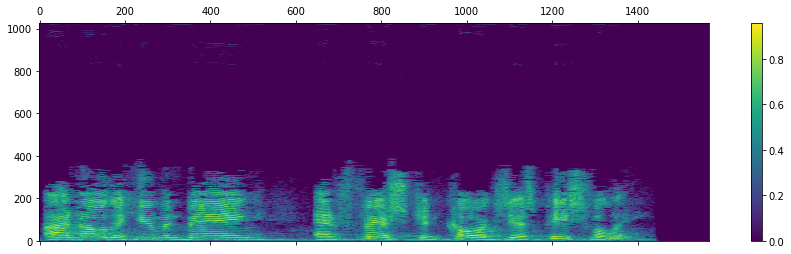

In [14]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(spectrogram.numpy().T, aspect='auto', origin='lower')
fig.colorbar(cax)

### Inverting the spectrogram
**Note: at the time of writing, tf.signal.istft is broken (2.0 alpha), so I'm implementing inversion partially in numpy. This should matter much in our case because inversion is being done offline.**

In [15]:
import librosa


def _istft(y, hparams):
    return librosa.istft(
        y, hop_length=hparams.hop_length, win_length=hparams.win_length
    )


def _stft(y, hparams):
    return librosa.stft(
        y=y,
        n_fft=hparams.n_fft,
        hop_length=hparams.hop_length,
        win_length=hparams.win_length,
    )


def _db_to_amp_tensorflow(x):
    return tf.pow(tf.ones(tf.shape(x)) * 10.0, x * 0.05)


# use this one when istft is fixed!
def _istft_tensorflow(stfts, hparams):
    return tf.signal.inverse_stft(
        stfts, hparams.win_length, hparams.hop_length, hparams.n_fft
    )


def _denormalize_tensorflow(S, hparams):
    return (tf.clip_by_value(S, 0, 1) * -hparams.min_level_db) + hparams.min_level_db


def _griffin_lim_tensorflow(S, hparams, use_tf_istft=False):
    """TensorFlow implementation of Griffin-Lim
  Based on https://github.com/Kyubyong/tensorflow-exercises/blob/master/Audio_Processing.ipynb and
  https://github.com/keithito/tacotron/blob/master/util/audio.py
  issue: https://github.com/tensorflow/tensorflow/issues/28444
  """
    # TensorFlow's stft and istft operate on a batch of spectrograms; create batch of size 1
    if use_tf_istft:
        S = tf.expand_dims(S, 0)
        S_complex = tf.identity(tf.cast(S, dtype=tf.complex64))
        y = tf.py_function(_istft(S_complex, hparams))
        for i in range(hparams.griffin_lim_iters):
            est = _stft_tensorflow(y)
            angles = est / tf.cast(tf.maximum(1e-8, tf.abs(est)), tf.complex64)
            y = _istft_tensorflow(S_complex * angles, hparams)
        return tf.squeeze(y, 0)

    else:
        angles = np.exp(2j * np.pi * np.random.rand(*S.shape))
        S_complex = np.abs(S).astype(np.complex)
        y = _istft(S_complex * angles, hparams)
        for i in range(hparams.griffin_lim_iters):
            angles = np.exp(1j * np.angle(_stft(y, hparams)))
            y = _istft(S_complex * angles, hparams)
        return y


def inv_spectrogram_tensorflow(spectrogram, hparams):
    """Converts spectrogram to waveform using librosa"""
    S = _db_to_amp_tensorflow(
        _denormalize_tensorflow(spectrogram, hparams) + hparams.ref_level_db
    )  # Convert back to linear
    return _griffin_lim_tensorflow(S ** hparams.power, hparams)  # Reconstruct phase

In [16]:
reconstructed_y = inv_spectrogram_tensorflow(np.transpose(spectrogram), hparams)

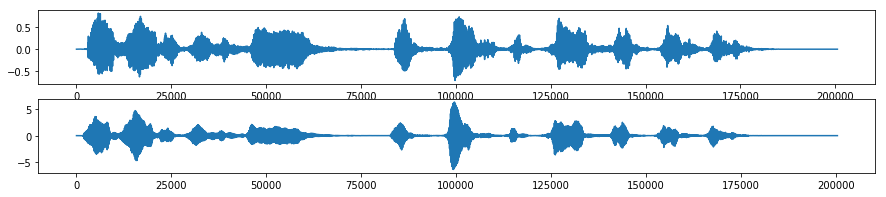

In [17]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(15,3))
axs[0].plot(data)
axs[1].plot(reconstructed_y)
IPython.display.Audio(data=reconstructed_y, rate=samplerate)

### Create the mel filter

In [18]:
# create a filter to convolve with the spectrogram
mel_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=hparams.num_mel_bins,
    num_spectrogram_bins=int(hparams.n_fft/2)+1,
    sample_rate=samplerate,
    lower_edge_hertz=hparams.mel_lower_edge_hertz,
    upper_edge_hertz=hparams.mel_upper_edge_hertz,
    dtype=tf.dtypes.float32,
    name=None,
)

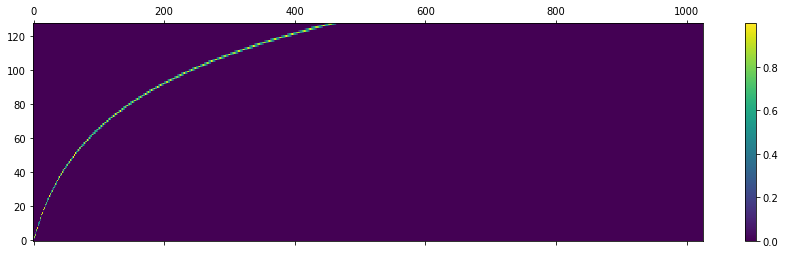

In [19]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(mel_matrix.numpy().T, aspect='auto', origin='lower')
fig.colorbar(cax)

#### This is what the mel spectrogram would look like if we didn't normalize the mel filter

In [20]:
mel_spectrogram = tf.tensordot(spectrogram,mel_matrix, 1)

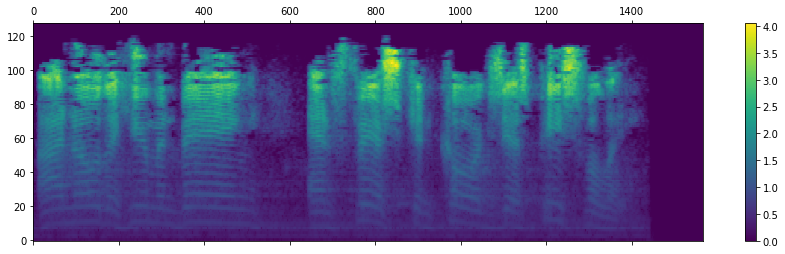

In [21]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(mel_spectrogram.numpy().T, aspect='auto', origin='lower')
fig.colorbar(cax)

### Normalize the mel filter

In [22]:
from librosa.core.time_frequency import mel_frequencies

In [23]:
# gets the center frequencies of mel bands
mel_f = mel_frequencies(
    n_mels=hparams.num_mel_bins + 2,
    fmin=hparams.mel_lower_edge_hertz,
    fmax=hparams.mel_upper_edge_hertz,
)

In [24]:
# Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
enorm = tf.dtypes.cast(
    tf.expand_dims(tf.constant(2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[:hparams.num_mel_bins])), 0),
    tf.float32,
)

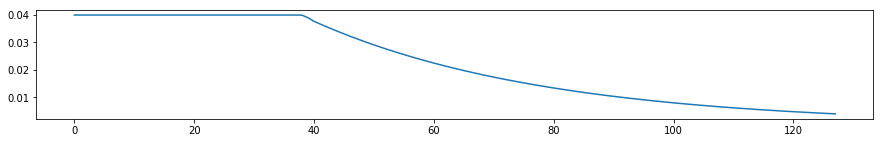

In [25]:
fig, ax = plt.subplots(ncols=1, figsize=(15,2))
ax.plot(enorm.numpy().T)

In [26]:
mel_matrix = tf.multiply(mel_matrix, enorm)

In [27]:
mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0))

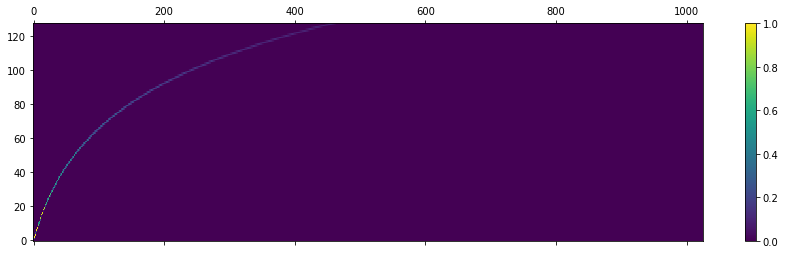

In [28]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(mel_matrix.numpy().T, aspect='auto', origin='lower')
fig.colorbar(cax)

### Create the Mel spectrogram

In [29]:
mel_spectrogram = tf.tensordot(spectrogram,mel_matrix, 1)

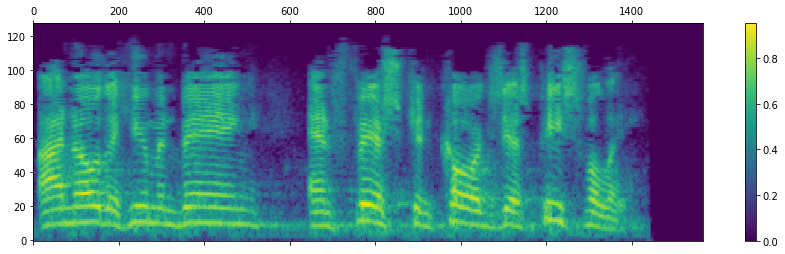

In [30]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(mel_spectrogram.numpy().T, aspect='auto', origin='lower')
fig.colorbar(cax)

### Get MFCCs

In [31]:
MFCCs = tf.signal.mfccs_from_log_mel_spectrograms(mel_spectrogram)

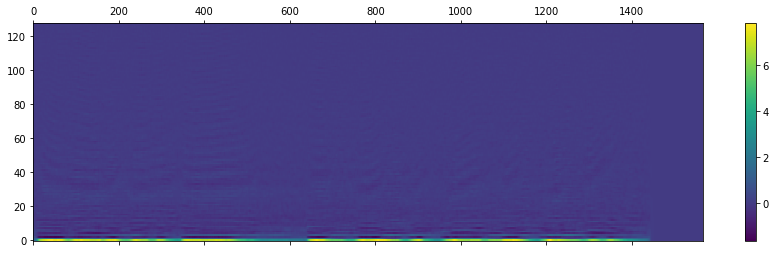

In [32]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow((MFCCs.numpy().T), aspect='auto', origin='lower')
fig.colorbar(cax)

### Create the mel inversion filter

In [33]:
with np.errstate(divide="ignore", invalid="ignore"):
    mel_inversion_matrix = tf.constant(
        np.nan_to_num(
            np.divide(mel_matrix.numpy().T, np.sum(mel_matrix.numpy(), axis=1))
        ).T
    )

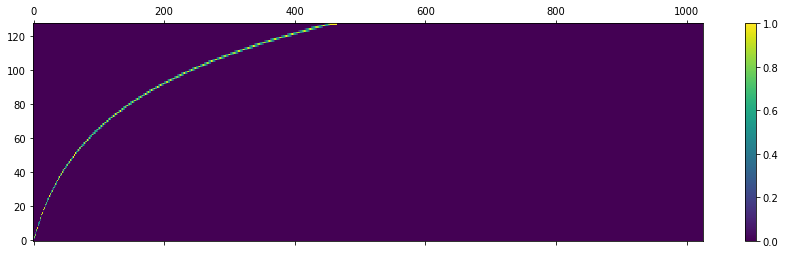

In [34]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(mel_inversion_matrix.numpy().T, aspect='auto', origin='lower')
fig.colorbar(cax)

### Invert from mel to linear

In [35]:
mel_spectrogram_inv = tf.tensordot(mel_spectrogram,tf.transpose(mel_inversion_matrix), 1)

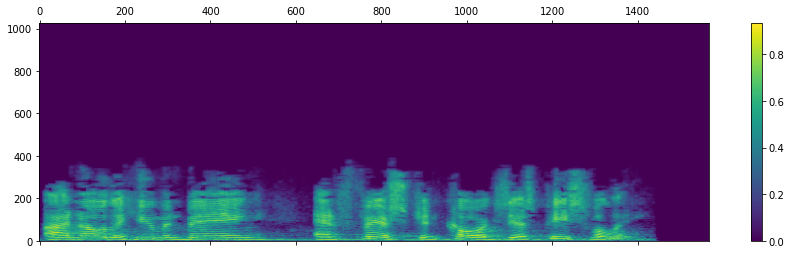

In [36]:
# compare lower frequencies to the original
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(mel_spectrogram_inv.numpy().T, aspect='auto', origin='lower')
fig.colorbar(cax)

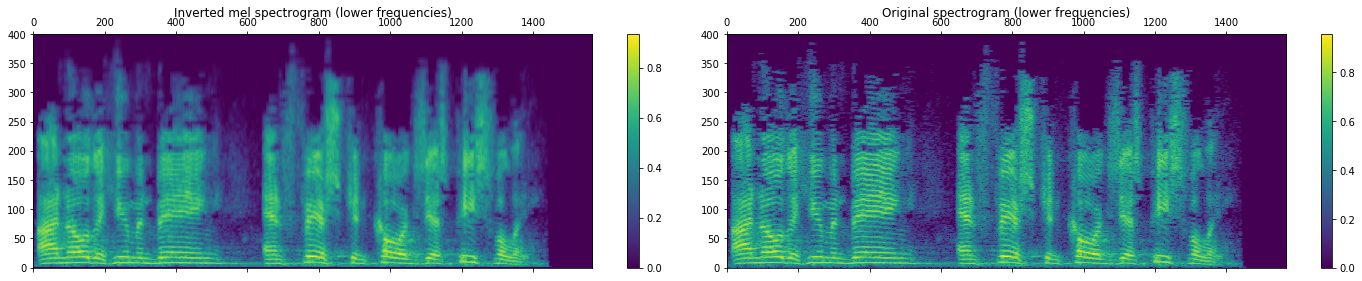

In [37]:
# compare lower frequencies to the original
fig, axs = plt.subplots(ncols=2, figsize=(20,4))
cax0 = axs[0].matshow(mel_spectrogram_inv.numpy().T[:400,:], aspect='auto', origin='lower')
fig.colorbar(cax0, ax=axs[0])
axs[0].set_title('Inverted mel spectrogram (lower frequencies)')
cax1 = axs[1].matshow(spectrogram.numpy().T[:400,:], aspect='auto', origin='lower')
fig.colorbar(cax1, ax=axs[1])
axs[1].set_title('Original spectrogram (lower frequencies)')
fig.tight_layout()

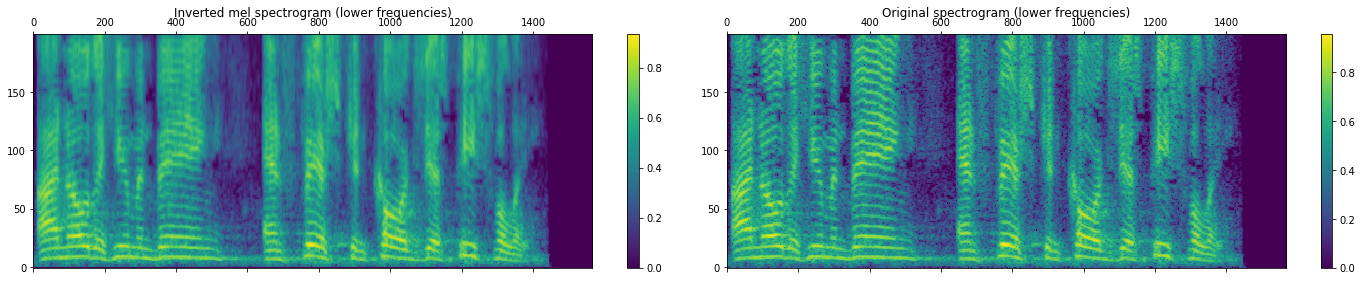

In [38]:
# compare lower frequencies to the original
fig, axs = plt.subplots(ncols=2, figsize=(20,4))
cax0 = axs[0].matshow(mel_spectrogram_inv.numpy().T[:200,:], aspect='auto', origin='lower')
fig.colorbar(cax0, ax=axs[0])
axs[0].set_title('Inverted mel spectrogram (lower frequencies)')
cax1 = axs[1].matshow(spectrogram.numpy().T[:200,:], aspect='auto', origin='lower')
fig.colorbar(cax1, ax=axs[1])
axs[1].set_title('Original spectrogram (lower frequencies)')
fig.tight_layout()

### Invert the mel spectrogram 

In [39]:
reconstructed_y_mel = inv_spectrogram_tensorflow(np.transpose(mel_spectrogram_inv), hparams)

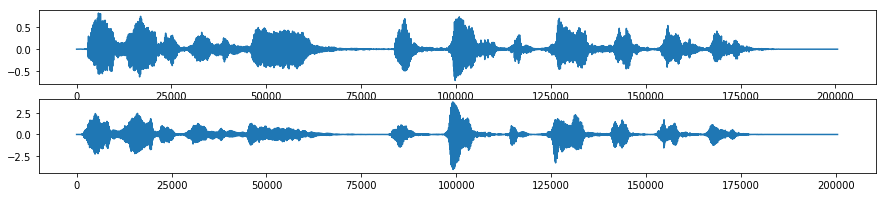

In [40]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(15,3))
axs[0].plot(data)
axs[1].plot(reconstructed_y_mel)
IPython.display.Audio(data=reconstructed_y_mel, rate=samplerate)